# Investigating Factors Affecting Housing Rental Yields (Using ONS Data)

## Purpose

The aim of this notebook is to use various public ONS (`https://www.ons.gov.uk/`) datasets to find factors affecting housing yields. I hope this will give readers (and potential investors) a better idea of what drives rental yields, hopefully allowing for better decision making.

Note: Here I look at yields instead of raw house prices since yields are comparable across different locations.

I approximate average yields using `median(rental income)/median(house price)` since the actual average yield, `median(rental income / house price)`, requires data for each house and is otherwise unavailable.


## Data Used

Below I list the ONS datasets I will be using. The full urls are given at the end.

- Crime
- Private Rental Statistics
- Median House Price
- Mean House Price
- Property Sales
- Population Estimates
- Quality of Life Estimates

These are the datasets I found on the ONS website I thought will be relevant and suitable to work with.

These give data reported by local authority so we will have a reasonable number of data points (roughly 300) to perform inference on.

In [49]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from ons_processing import parse_files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data
We call all `parse_*` functions in `parse_files.py` to load all collected datasets and join on `la_code`.

In [92]:
csv_dir = "./ons_processing/data"
datasets = ["property_sales", "crime", "rental_summary", "population_age", "wellbeing", "property_prices"]
data = {k: getattr(parse_files, f"parse_{k}")(csv_dir) for k in datasets}
print({k: df.shape for k, df in data.items()})

{'property_sales': (336, 2), 'crime': (311, 4), 'rental_summary': (357, 4), 'population_age': (331, 6), 'wellbeing': (421, 5), 'property_prices': (331, 2)}


/home/nikul/Documents/Programming/ons_housing/ons_processing/parse_files.py:21: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path, **read_kwargs)


## Data Cleaning
We lose some data in the joining process because not all datasets have data for all local authorities. Imputing these values would introduce too much noise (we go from roughly 330 areas per dataset before joining to roughly 270 after joining) since the % of lost data points is large.


We also have some missing data after joining. Let's investigate whether it will be sensible to impute these values or to drop them.

In [152]:
from functools import reduce
joined = reduce(lambda x, y: x.merge(y, on="la_code"), data.values()) # merge all dataframes on la code
print(joined.shape)

(267, 18)


### Missing Values
We can see num_households, total_crime, burgalry_per_household are not inferred as numeric types. Looking at the raw data we can see this is because there are missing values marked as `[x]`.

In [153]:
joined.dtypes

la_code                    object
num_sold                  float64
num_households             object
total_crime                object
burgalry_per_household     object
rent_count                  int64
median_rent                 int64
mean_rent                   int64
la_name                    object
total_population            int64
child                       int64
adult                       int64
elderly                     int64
anxiety                   float64
happiness                 float64
life-satisfaction         float64
worthwhile                float64
property_price              int64
dtype: object

In [157]:
to_convert = ["num_households", "total_crime", "burgalry_per_household"]

for col in to_convert:
    joined.loc[:, col] = pd.to_numeric(joined[col], errors="coerce")

### Imputing Data
There are only a few data points with missing values. Their distributions look relatively simple, so let's impute them by replacing the missing values with their respective medians to avoid data loss (at the expense of possibly introducing biases/noise to the data).

In [165]:
num_missing = joined.isna().sum()
num_missing = num_missing[num_missing!=0]
print(num_missing)

total_crime               11
burgalry_per_household    11
anxiety                    5
happiness                  3
life-satisfaction          3
worthwhile                 3
dtype: int64


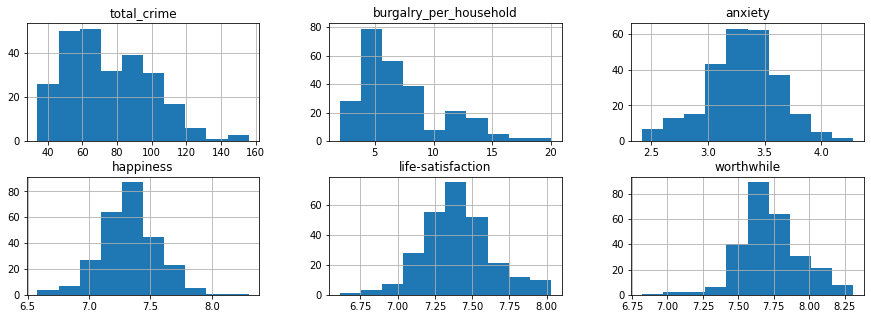

In [176]:
import matplotlib.pyplot as plt
_ = joined[num_missing.index].hist(figsize=(15, 5), layout=(2, 3))
plt.show()

In [182]:
joined = joined.fillna(joined[num_missing.index].median()) # replace missing values with their medians

In [186]:
print(joined.shape) # we lose 5 data points
joined.to_parquet("./ons_processing/data/joined.pq") # save for convenience

(267, 18)


## Exploratory Data Analysis
Now that we've prepared the raw data we'll be using, let's explore it.

In [187]:
joined = pd.read_parquet("./ons_processing/data/joined.pq") # load previously saved results

### Distribution Plots
Let's look at how the individual features are distributed. Some observations:

- Data directly to do with property + population (num_sold, median_rent, total_population, ...) tend to be highly positively skewed
  - This is likely from a few outlier regions with large populations (eg areas in London)
- The life satisfaction measures (happiness, ...) have almost no skew, but I would have expected skew for the same reason why the other fields are skewed
  - These measures are highly subjective however, so could impact their effectiveness as a predictor

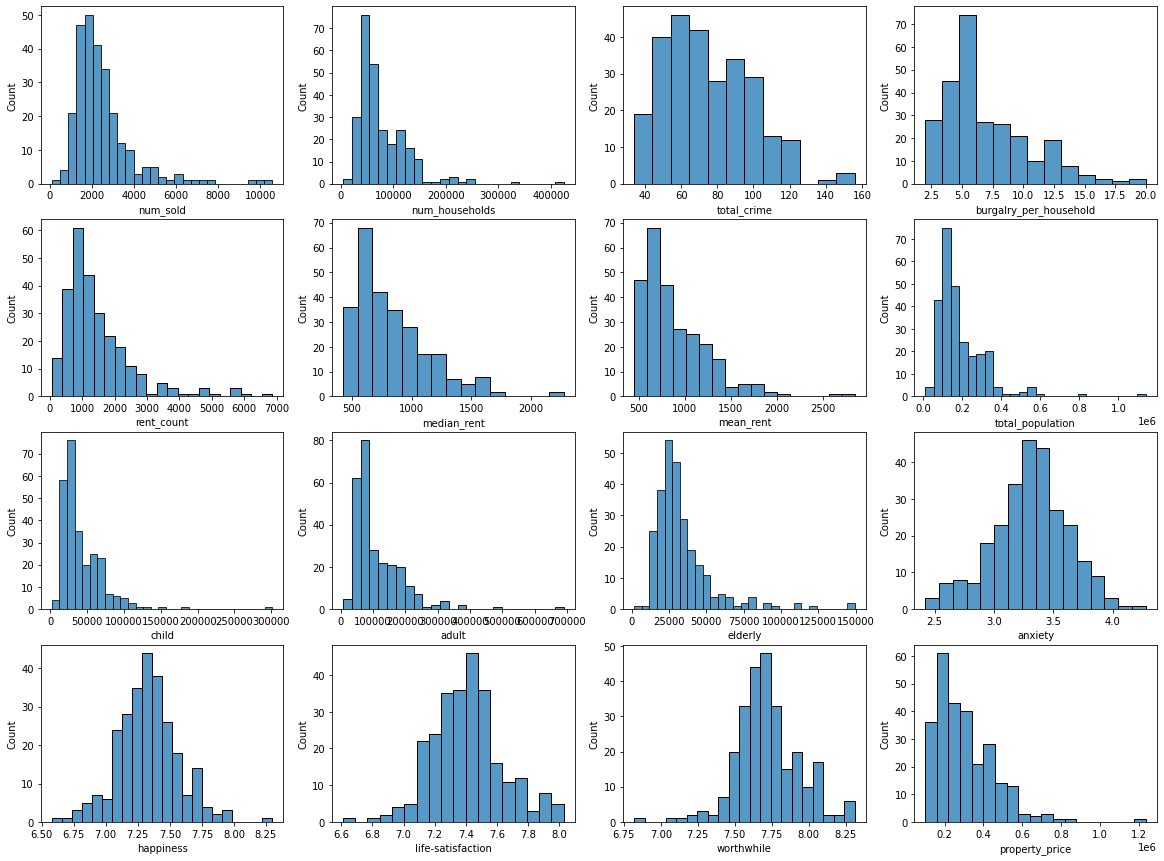

In [189]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(20, 15))
to_exclude = ["la_code", "la_name"]
to_boxplot = [k for k in joined.columns if k not in to_exclude]

for col, ax_ in zip(to_boxplot, ax.ravel()):
    sns.histplot(joined[col], ax=ax_)

### Data Sanity Check
Let's do a quick sanity check on the data by looking at the areas with the highest house prices. These are all in Central London which matches with expectations.

In [197]:
i = joined.property_price.sort_values().tail(5).index
print(joined.iloc[i][["la_name", "property_price"]])

                    la_name  property_price
234          City of London          720000
246  Hammersmith and Fulham          750000
240                  Camden          777000
266             Westminster          865000
253  Kensington and Chelsea         1237500


### Pairwise Distribution Plots
Let's now look at some pairwise plots between the data columns. I've chosen a subset of columns to plot for clarity. Some observations:

- We see some expected relationships, eg property price:
  - increases (almost linearly) with median rent
  - generally increases with increased population
  - generally decreases with increased crime
- Happiness doesn't seem to be related to anything
  - This is consistent with the prior observation that since it is subjective, it may lack predictive ability

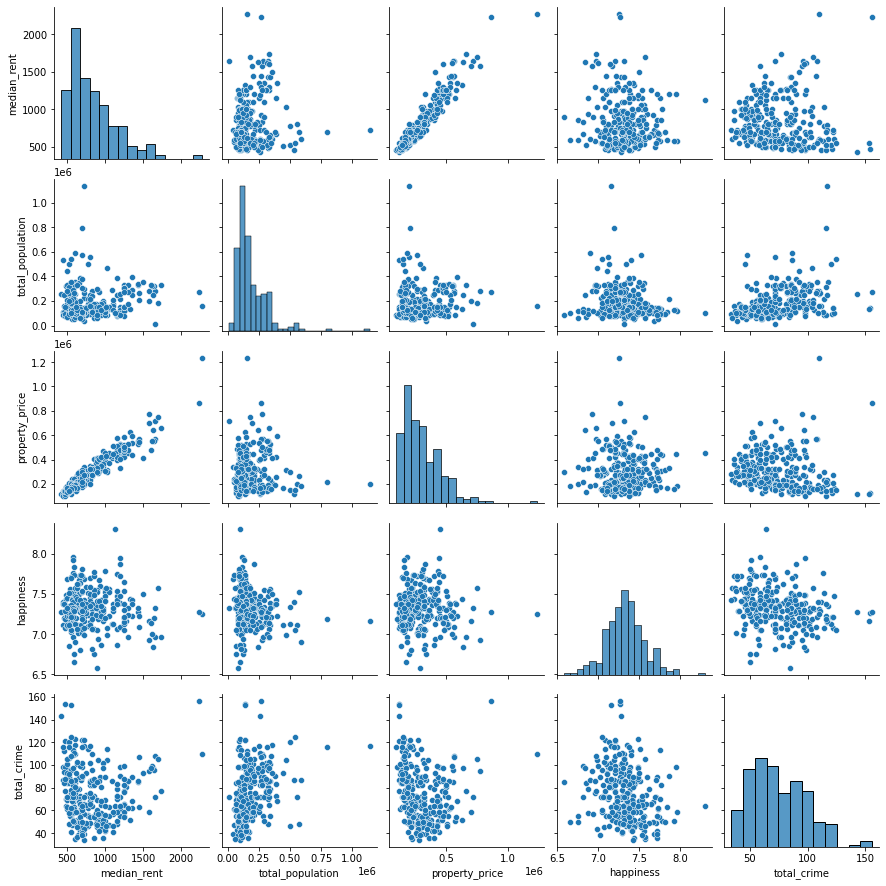

In [205]:
import seaborn as sns

pairplot_subset = ["median_rent", "total_population", "property_price", "happiness", "total_crime"]
sns.pairplot(joined[pairplot_subset])
plt.show()

## Feature Engineering
Now we've had an initial look at the data, let's create some features that can be compared across regions so we can better analyse the data.

Specifically, we will create unitless quantities (eg crime per capita instead of total crime) that can be compared across local areas.

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="myApp")

def query_location(la_name):
    """Use geopy to find the full location string and (latitude, longitude)
    coordinates of the given local authority name
    """
    location = geolocator.geocode(f"{k}, UK")
    if location:
        return location
    return (np.nan, np.nan) # failed to find location
    

## Data Sources

Crime
- https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/recordedcrimedatabycommunitysafetypartnershiparea

Private Rental Statistics
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/privaterentalmarketsummarystatisticsinengland

Median House Price
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37

Mean House Price
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/meanpricepaidbywardhpssadataset38

Property Sales
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/numberofresidentialpropertysalesbywardhpssadataset36

Population Estimates
- https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental

Quality of Life Estimates
- https://www.ons.gov.uk/datasets/wellbeing-local-authority/editions/time-series/versions/2

Note: the ONS has an API (https://developer.ons.gov.uk/) however these not all of these datasets are not available through this at the time of writing. Also, due issues parsing these excel files, I have manually exported the data to csvs which can be straightforwardly parsed.